In [4]:
%matplotlib inline

import tensorflow as tf
import pysam
from operator import itemgetter
from sequencing_tools.fastq_tools import reverse_complement, kmer_bag, onehot_sequence_encoder
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import Binarizer, label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv1D,\
                    Flatten, MaxPool1D,  \
                    Dropout, LSTM, \
                    Bidirectional
from keras import optimizers

In [6]:
test_bed = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/classifier/test.bed'
fa_file = '/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa'

In [8]:
acceptable_chrom = list(range(1,23))
acceptable_chrom.extend(['X','Y'])
acceptable_chrom = ['chr' + str(chrom) for chrom in acceptable_chrom]

def get_seq(bed_file, fasta):
    genome_fa = pysam.Fastafile(fasta)
    for line in open(bed_file):
        fields = line.rstrip('\n').split('\t')
        chrom, start, end, strand, label = itemgetter(0,1,2,5, -1)(fields)
        if chrom in acceptable_chrom:
            seq = genome_fa.fetch(chrom, int(start), int(end))
            seq = reverse_complement(seq) if seq == "-" else seq
            seq = seq.upper() 
            yield seq, label

# A random forest classifier with kmer-bag method#

In [10]:
def extract_data(bed_file, fasta):
    for i, (seq, label) in enumerate(get_seq(bed_file, fasta)):
        kmers = kmer_bag(seq, k_start =  2, k_end = 6)
        outid = 'read%i' %(i+1)
        for kmer, kmer_count in kmers.items():
            yield(outid, kmer, kmer_count, label)

In [12]:
data_generator = extract_data(test_bed, fa_file)
kdf = pd.DataFrame(data_generator,
                  columns = ['read_id','kmer','kmer_count','label'])
kdf.head()

,read_id,kmer,kmer_count,label
0,read1,TG,2,DNA
1,read1,GA,6,DNA
2,read1,AG,5,DNA
3,read1,GG,2,DNA
4,read1,AA,8,DNA


In [14]:
sdf = kdf\
    .pipe(pd.pivot_table, 
        index = ['read_id','label'],
        columns = 'kmer',
        values = 'kmer_count',
        fill_value = 0) \
    .reset_index()
sdf.head()

kmer,read_id,label,AA,AAA,AAAA,AAAAA,AAAAC,AAAAG,AAAAT,AAAC,...,TTTG,TTTGA,TTTGC,TTTGG,TTTGT,TTTT,TTTTA,TTTTC,TTTTG,TTTTT
0,read1,DNA,8,2,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,read10,DNA,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2,read100,DNA,12,3,0,0,0,0,0,1,...,2,0,0,0,2,3,0,0,2,1
3,read1000,DNA,16,5,3,1,0,1,1,0,...,0,0,0,0,0,2,1,0,0,1
4,read10000,DNA,11,4,1,0,0,1,0,1,...,0,0,0,0,0,1,1,0,0,0


In [16]:
X = sdf.filter(regex = '[ACTG]')
Y = sdf.label

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [ ]:
rf = RandomForestClassifier(oob_score=False)
rf_cv = GridSearchCV(rf, 
                     n_jobs = 24,
                     param_grid = {'n_estimators': np.arange(10,30)})
rf_cv.fit(X_train, y_train)

In [ ]:
y_pred = rf_cv.best_estimator_.predict_proba(X_test)[:, 1].round()
y_test_code = y_test.astype('category').cat.codes

print("Precision: %1.3f" % precision_score(y_test_code, y_pred))
print("Recall: %1.3f" % recall_score(y_test_code, y_pred))
print("F1: %1.3f" % f1_score(y_test_code, y_pred))
print("AUROC: %1.3f" % roc_auc_score(y_test_code, y_pred))

In [ ]:
ax = plt.subplot(111)
sns.barplot(data = pd.DataFrame({'features':X.columns,
                      'importance': rf_cv.best_estimator_.feature_importances_
                     }) \
                .sort_values('importance', ascending=False)\
                .head(30),
            x = 'features',
            y = 'importance', 
            color = 'steelblue',
            ax = ax)
xt = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
sns.despine()

# Try tensorflow neuralnet #

In [13]:
frag_size = 600
acceptable_chrom = list(range(1,23))
acceptable_chrom.append(['X','Y'])
dna_encoder = onehot_sequence_encoder('ACTGN')


def get_unpadded_seq(bed_file, fasta):
    genome_fa = pysam.Fastafile(fasta)
    for line in open(bed_file):
        fields = line.rstrip('\n').split('\t')
        chrom, start, end, strand, label = itemgetter(0,1,2,5, -1)(fields)
        center = (int(end) + int(start)) / 2
        if chrom != 'chrM':
            seq = genome_fa.fetch(chrom, int(center) - frag_size/2, int(center) + frag_size/2)
            seq = reverse_complement(seq) if seq == "-" else seq
            seq = seq.upper() 
            yield seq, label


def generate_data(bed_file, fasta):
    for i, (seq, label) in enumerate(get_unpadded_seq(bed_file, fasta)):
        yield(dna_encoder.transform(seq), label)
            
    
def get_padded_seq(bed_file, fasta):
    genome_fa = pysam.Fastafile(fasta)
    for line in open(bed_file):
        fields = line.rstrip('\n').split('\t')
        chrom, start, end, strand, label = itemgetter(0,1,2,5, -1)(fields)
        if chrom != 'chrM':
            seq_length = int(end) - int(start)
            if seq_length < frag_size:
                padding_base = frag_size - seq_length
                half_padding = int(padding_base/2)
                seq = genome_fa.fetch(chrom, int(start), int(end))
                seq = half_padding * 'N' + seq + (half_padding + 1) * 'N'

            else:
                center = (int(end) + int(start)) / 2
                seq = genome_fa.fetch(chrom, int(center) - frag_size/2, int(center) + frag_size/2)
                seq = reverse_complement(seq) if seq == "-" else seq
                seq = seq.upper() 
            yield seq[:frag_size], label


acceptable_nuc = set('ACTGN')
def generate_padded_data(bed_file, fasta):
    for i, (seq, label) in enumerate(get_padded_seq(bed_file, fasta)):
        if set(seq).issubset(acceptable_nuc):
            yield(dna_encoder.transform(seq), label)

In [14]:
help(onehot_sequence_encoder)

Help on class onehot_sequence_encoder in module sequencing_tools.fastq_tools._fastq_tools:

class onehot_sequence_encoder(builtins.object)
 |  A onehot encoder for DNA sequence
 |  
 |  usage:
 |      dna_encoder = onehot_sequence_encoder()
 |      onehot_encoded_matrix = dna_encoder.fit_transform(sequence)
 |      dna_encoder.base_encoder  # check which base each column represents
 |  
 |  Methods defined here:
 |  
 |  __init__(self, bases='ACTGN')
 |  
 |  fit(self, bases='ACTGN')
 |  
 |  fit_transform(self, sequence)
 |      One hot sequence encoder
 |      
 |      Parameter:
 |          sequence: a string of sequence, only accept 'ACTGN'
 |      
 |      return:
 |          onehot encoded array:  len(sequence)-by-distinct(base) matrix
 |                                  columns represent each base
 |                                  rows represent each position along the sequence
 |  
 |  transform(self, sequence)
 |      One hot sequence encoder
 |      
 |      Parameter:
 |  

In [15]:
data = [(seq, lab) for seq, lab in generate_padded_data(test_bed, fa_file)]
seqs, labels = zip(*data)

In [16]:
seqs = np.array(seqs)
labels = np.array(labels)
encoded_label = np.where(labels == "DNA", 1, 0)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(seqs, encoded_label, 
                                                    test_size=0.2, 
                                                    random_state=0)

In [18]:
X_train.shape

(26545, 600, 5)

In [19]:
# from DanQ
'''
model = Sequential()
model.add(Convolution1D(input_dim=4,
                        input_length=1000,
                        nb_filter=320,
                        filter_length=26,
                        border_mode="valid",
                        activation="relu",
                        subsample_length=1))
model.add(MaxPooling1D(pool_length=13, stride=13))
model.add(Dropout(0.2))
model.add(brnn)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(input_dim=75*640, output_dim=925))
model.add(Activation('relu'))
model.add(Dense(input_dim=925, output_dim=919))
model.add(Activation('sigmoid'))
print 'compiling model'
model.compile(loss='binary_crossentropy', optimizer='rmsprop', class_mode="binary")
'''

model = Sequential()
model.add(Conv1D(filters=160, 
                 kernel_size = 26,
                 strides = 1,
                 padding = 'valid',
                 input_shape = (frag_size, 5),
                 activation = 'relu'))
model.add(MaxPool1D(pool_size=50, strides=13))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
#model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['binary_accuracy'])
model.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 575, 160)          20960     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 41, 160)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 41, 160)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               115200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                3225      
___________________________________________________________

In [25]:
history = model.fit(X_train, y_train, 
                    validation_split = 0.1,
                    epochs = 25)

Train on 23890 samples, validate on 2655 samples
Epoch 1/25
23890/23890 [==============================] - 51s 2ms/step - loss: 0.0815 - binary_accuracy: 0.9704 - val_loss: 0.6969 - val_binary_accuracy: 0.8512
Epoch 2/25
23890/23890 [==============================] - 51s 2ms/step - loss: 0.0800 - binary_accuracy: 0.9707 - val_loss: 0.4445 - val_binary_accuracy: 0.8719
Epoch 3/25
23890/23890 [==============================] - 51s 2ms/step - loss: 0.0813 - binary_accuracy: 0.9716 - val_loss: 0.4709 - val_binary_accuracy: 0.8731
Epoch 4/25
23890/23890 [==============================] - 52s 2ms/step - loss: 0.0749 - binary_accuracy: 0.9729 - val_loss: 0.5060 - val_binary_accuracy: 0.8648
Epoch 5/25
23890/23890 [==============================] - 51s 2ms/step - loss: 0.0750 - binary_accuracy: 0.9742 - val_loss: 0.6623 - val_binary_accuracy: 0.8738
Epoch 6/25
23890/23890 [==============================] - 51s 2ms/step - loss: 0.0759 - binary_accuracy: 0.9740 - val_loss: 0.4443 - val_binary_ac

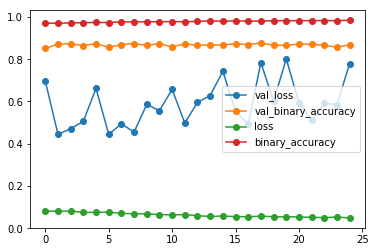

In [26]:
ax = plt.subplot(111)
for key, vals in history.history.items():
    ax.plot(np.arange(len(vals)), vals, '-o',  label = key)
ax.legend()

In [27]:
y_pred = model.predict_classes(X_test)
y_pred = y_pred.flatten()

print("Precision: %1.3f" % precision_score(y_test, y_pred))
print("Recall: %1.3f" % recall_score(y_test, y_pred))
print("F1: %1.3f" % f1_score(y_test, y_pred))
print("AUROC: %1.3f" % roc_auc_score(y_test, y_pred))

Precision: 0.902
Recall: 0.869
F1: 0.885
AUROC: 0.869


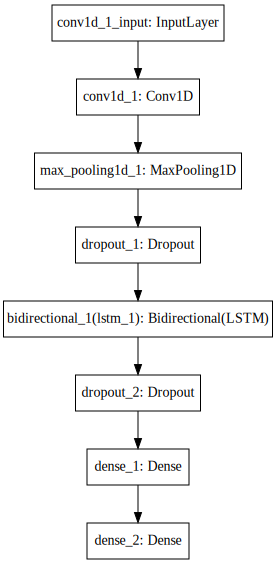

In [28]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
set('aaacct').issubset(set('act'))